# Multivariate analysis

The objective of this notebook is to analyze how multiple variables interact simultaneously.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency, ks_2samp, anderson
import statsmodels.api as sm
from statsmodels.formula.api import ols
import category_encoders as ce

import os
import sys 
import warnings
import pickle
from IPython.display import Image



warnings.filterwarnings("ignore")

images_directory = 'images/images_multivar_analysis'
os.makedirs(images_directory, exist_ok=True)

pickle_directory = 'variables/variables_multivar_analysis'
os.makedirs(pickle_directory, exist_ok=True)

In [2]:
data = pd.read_parquet('../data/silver/df_fraud_bivar.parquet', engine= 'fastparquet')
data

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,diffbalanceOrig,diffbalanceDest
0,1,PAYMENT,9.839640e+03,C1231006815,170136.000,160296.359375,M1979787155,0.000000e+00,0.000,no_fraud,1,1.000-10.000,-9.839641e+03,0.000
1,1,PAYMENT,1.864280e+03,C1666544295,21249.000,19384.720703,M2044282225,0.000000e+00,0.000,no_fraud,1,1.000-10.000,-1.864279e+03,0.000
2,1,TRANSFER,1.810000e+02,C1305486145,181.000,0.000000,C553264065,0.000000e+00,0.000,fraud,1,0-1.000,-1.810000e+02,0.000
3,1,CASH_OUT,1.810000e+02,C840083671,181.000,0.000000,C38997010,2.118200e+04,0.000,fraud,1,0-1.000,-1.810000e+02,-21182.000
4,1,PAYMENT,1.166814e+04,C2048537720,41554.000,29885.859375,M1230701703,0.000000e+00,0.000,no_fraud,1,10.000-100.000,-1.166814e+04,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,3.396821e+05,C786484425,339682.125,0.000000,C776919290,0.000000e+00,339682.125,fraud,31,100.000-1.000.000,-3.396821e+05,339682.125
6362616,743,TRANSFER,6.311410e+06,C1529008245,6311409.500,0.000000,C1881841831,0.000000e+00,0.000,fraud,31,1.000.000-10.000.000,-6.311410e+06,0.000
6362617,743,CASH_OUT,6.311410e+06,C1162922333,6311409.500,0.000000,C1365125890,6.848884e+04,6379898.000,fraud,31,1.000.000-10.000.000,-6.311410e+06,6311409.000
6362618,743,TRANSFER,8.500025e+05,C1685995037,850002.500,0.000000,C2080388513,0.000000e+00,0.000,fraud,31,100.000-1.000.000,-8.500025e+05,0.000


nameorig con fraud con type

KeyboardInterrupt: 

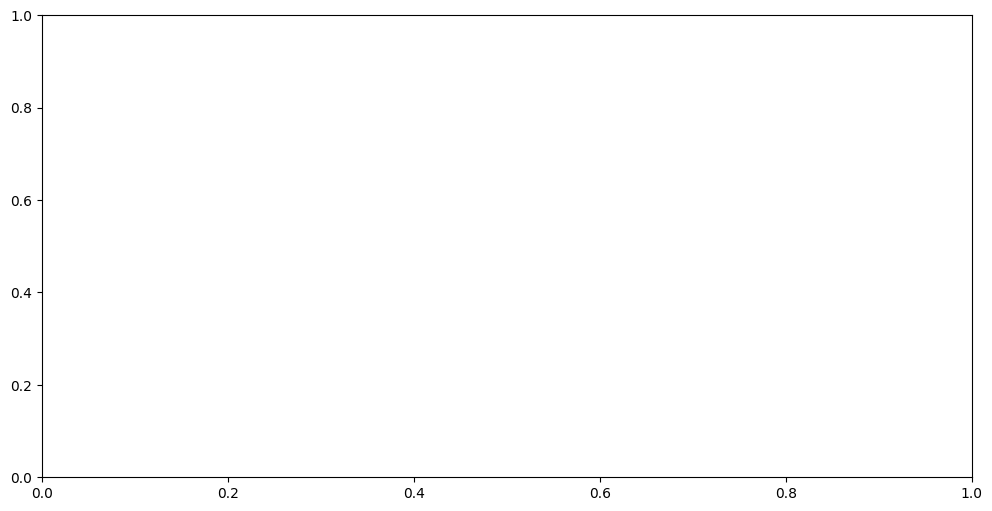

In [3]:
boxplot_filename = 'boxplot_nameOrig_vs_fraud_and_type.png'
boxplot_filepath = os.path.join(images_directory, boxplot_filename)

if not os.path.isfile(boxplot_filepath):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='type', y='nameOrig', hue='isFraud', data=data, palette='pastel')
    plt.title('Box Plot of nameOrig by Fraud Status and Type')
    plt.xlabel('Type')
    plt.ylabel('nameOrig')
    plt.tight_layout()
    plt.savefig(boxplot_filepath)
    plt.close()

Image(filename=boxplot_filepath)

nameorig con fraud ambiguo con type de transaction...son robadas?

estudiar los balances con 0 euros con type

estudiar oldbalanceorig = 0 cuando es fraud y el amount_range

estudiar oldbalanceorig = 0 cuando es fraud y el type

I will reduce the number of rows due to lack of computational resources

In [ ]:

# Check if my dataset contains all steps 
# Create set with ranges of steps
expected_steps = set(range(1, 275))

# Get unique values of the dataset
actual_steps = set(data['step'].unique())

# Missing values if there are
missing_steps = expected_steps - actual_steps

if missing_steps:
    print(f" Missing values in 'step': {sorted(missing_steps)}")
else:
    print("The column 'step' contains all values from 1 to 274")

The column 'step' contains all values


In [5]:
step_counts = data['step'].value_counts()
valid_steps = step_counts[step_counts >= 2].index
filtered_df = data[data['step'].isin(valid_steps)]
subset = filtered_df.groupby('step').sample(n=2, random_state=42)


In [6]:
subset

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,diffbalanceOrig,diffbalanceDest
1044,1,PAYMENT,4.518420e+03,C1504321715,8.790000e+03,4.271580e+03,M910123336,0.000000e+00,0.000000e+00,no_fraud,1,1.000-10.000,-4518.419922,0.00000
439,1,CASH_IN,1.314093e+05,C1476235721,8.491742e+06,8.623151e+06,C1068824137,2.902760e+05,2.650924e+05,no_fraud,1,100.000-1.000.000,131409.000000,-25183.65625
3718,2,PAYMENT,5.621400e+02,C837981622,7.221367e+05,7.215745e+05,M2053668237,0.000000e+00,0.000000e+00,no_fraud,1,0-1.000,-562.187500,0.00000
2919,2,CASH_IN,8.851071e+04,C2145921383,5.775554e+06,5.864064e+06,C977993101,1.180073e+06,7.442649e+05,no_fraud,1,10.000-100.000,88510.500000,-435807.81250
3957,3,CASH_IN,1.684791e+05,C1644155208,6.673927e+06,6.842406e+06,C575335780,3.086425e+05,1.401634e+05,no_fraud,1,100.000-1.000.000,168479.000000,-168479.09375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362584,741,TRANSFER,5.674548e+06,C992223106,5.674548e+06,5.674548e+06,C1366804249,0.000000e+00,0.000000e+00,fraud,31,1.000.000-10.000.000,0.000000,0.00000
6362608,742,TRANSFER,2.583554e+05,C1226129332,2.583554e+05,0.000000e+00,C1744173808,0.000000e+00,0.000000e+00,fraud,31,100.000-1.000.000,-258355.421875,0.00000
6362601,742,CASH_OUT,6.529939e+05,C1614818636,6.529939e+05,0.000000e+00,C362803701,0.000000e+00,6.529939e+05,fraud,31,100.000-1.000.000,-652993.937500,652993.93750
6362619,743,CASH_OUT,8.500025e+05,C1280323807,8.500025e+05,0.000000e+00,C873221189,6.510099e+06,7.360102e+06,fraud,31,100.000-1.000.000,-850002.500000,850002.50000


In [7]:
subset.to_parquet('../data/gold/df_fraud_final.parquet', engine= 'fastparquet')

In [8]:
subset

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,day_of_month,amount_range,diffbalanceOrig,diffbalanceDest
1044,1,PAYMENT,4.518420e+03,C1504321715,8.790000e+03,4.271580e+03,M910123336,0.000000e+00,0.000000e+00,no_fraud,1,1.000-10.000,-4518.419922,0.00000
439,1,CASH_IN,1.314093e+05,C1476235721,8.491742e+06,8.623151e+06,C1068824137,2.902760e+05,2.650924e+05,no_fraud,1,100.000-1.000.000,131409.000000,-25183.65625
3718,2,PAYMENT,5.621400e+02,C837981622,7.221367e+05,7.215745e+05,M2053668237,0.000000e+00,0.000000e+00,no_fraud,1,0-1.000,-562.187500,0.00000
2919,2,CASH_IN,8.851071e+04,C2145921383,5.775554e+06,5.864064e+06,C977993101,1.180073e+06,7.442649e+05,no_fraud,1,10.000-100.000,88510.500000,-435807.81250
3957,3,CASH_IN,1.684791e+05,C1644155208,6.673927e+06,6.842406e+06,C575335780,3.086425e+05,1.401634e+05,no_fraud,1,100.000-1.000.000,168479.000000,-168479.09375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362584,741,TRANSFER,5.674548e+06,C992223106,5.674548e+06,5.674548e+06,C1366804249,0.000000e+00,0.000000e+00,fraud,31,1.000.000-10.000.000,0.000000,0.00000
6362608,742,TRANSFER,2.583554e+05,C1226129332,2.583554e+05,0.000000e+00,C1744173808,0.000000e+00,0.000000e+00,fraud,31,100.000-1.000.000,-258355.421875,0.00000
6362601,742,CASH_OUT,6.529939e+05,C1614818636,6.529939e+05,0.000000e+00,C362803701,0.000000e+00,6.529939e+05,fraud,31,100.000-1.000.000,-652993.937500,652993.93750
6362619,743,CASH_OUT,8.500025e+05,C1280323807,8.500025e+05,0.000000e+00,C873221189,6.510099e+06,7.360102e+06,fraud,31,100.000-1.000.000,-850002.500000,850002.50000
